In [1]:
import logging

logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%d-%b-%y %H:%M:%S',
                    level=logging.INFO
                   )


logging.info('Importing standard python libraries')
from pathlib import Path

logging.info('Importing third party python libraries')
import numpy as np
import xarray as xr
import xmitgcm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib import colors, rc
import cmocean.cm as cmo
import f90nml
import pvcalc

09-Aug-22 16:19:31 - Importing standard python libraries
09-Aug-22 16:19:31 - Importing third party python libraries


KeyboardInterrupt: 

In [ ]:
logging.info('Setting paths')
base_path = Path('/work/n01/n01/fwg/irminger-proj')
raw_path = base_path / 'data/raw'
processed_path = base_path / 'data/processed'
figure_path = base_path / 'figures'

run_path = raw_path / '2d-models/run25mNH'
assert run_path.exists()

09-Aug-22 16:09:42 - Setting paths


In [ ]:
logging.info('Reading in model parameters from the namelist')
with open(run_path / 'data') as data:
    data_nml = f90nml.read(data)

delta_t = data_nml['parm03']['deltat']
f0 = data_nml['parm01']['f0']
beta = data_nml['parm01']['beta']
no_slip_bottom = data_nml['parm01']['no_slip_bottom']
no_slip_sides = data_nml['parm01']['no_slip_sides']


logging.info('Reading in the model dataset')
ds = xmitgcm.open_mdsdataset(str(run_path),
                             prefix=['ZLevelVars', 'IntLevelVars'],
                             delta_t=delta_t,
                             geometry='cartesian')

09-Aug-22 16:09:42 - Reading in model parameters from the namelist
09-Aug-22 16:09:42 - Reading in the model dataset


In [ ]:
logging.info('Calculating the potential vorticity')
grid = pvcalc.create_xgcm_grid(ds)
ds['drL'] = pvcalc.create_drL_from_dataset(ds)
ds['rho'] = pvcalc.calculate_density(ds['RHOAnoma'], ds['rhoRef'])
ds['b'] = pvcalc.calculate_buoyancy(ds['rho'])

ds['db_dx'], ds['db_dy'], ds['db_dz'] = pvcalc.calculate_grad_buoyancy(ds['b'], ds, grid)
ds['db_dz'] = ds['db_dz'] * xr.where(grid.interp(ds['maskC'], ['Z'], to={'Z': 'right'}, boundary='fill') == 0, np.nan, 1)

ds['zeta_x'], ds['zeta_y'], ds['zeta_z'] = pvcalc.calculate_curl_velocity(ds['UVEL'],
                                                                          ds['VVEL'],
                                                                          ds['WVEL'],
                                                                          ds,
                                                                          grid,no_slip_bottom,
                                                                          no_slip_sides
                                                                         )
ds['NaNmaskC'] = xr.where(ds['maskC'] == 1, 1, np.NaN)
ds['maskQ'] = grid.interp(ds['maskW'], ['Y', 'Z'], to={'Z': 'right', 'Y': 'left'}, boundary='fill')
ds['Q'] = pvcalc.calculate_C_potential_vorticity(ds['zeta_x'],
                                                 ds['zeta_y'],
                                                 ds['zeta_z'],
                                                 ds['b'],
                                                 ds,
                                                 grid,
                                                 beta,
                                                 f0
                                                 ) * xr.where(ds['maskQ'] == 0, np.nan, 1)

ds

09-Aug-22 16:09:48 - Calculating the potential vorticity


<xarray.Dataset>
Dimensions:   (XC: 6000, YC: 1, XG: 6000, YG: 1, Z: 500, Zp1: 501, Zu: 500,
               Zl: 500, time: 90)
Coordinates: (12/34)
  * XC        (XC) >f4 12.5 37.5 62.5 87.5 ... 1.499e+05 1.5e+05 1.5e+05
  * YC        (YC) >f4 12.5
  * XG        (XG) >f4 0.0 25.0 50.0 75.0 ... 1.499e+05 1.5e+05 1.5e+05
  * YG        (YG) >f4 0.0
  * Z         (Z) >f4 -0.5 -1.5 -2.5 -3.5 -4.5 ... -496.5 -497.5 -498.5 -499.5
  * Zp1       (Zp1) >f4 0.0 -1.0 -2.0 -3.0 -4.0 ... -497.0 -498.0 -499.0 -500.0
    ...        ...
    dyF       (YC, XC) >f4 dask.array<chunksize=(1, 6000), meta=np.ndarray>
    dxF       (YC, XC) >f4 dask.array<chunksize=(1, 6000), meta=np.ndarray>
    dxV       (YG, XG) >f4 dask.array<chunksize=(1, 6000), meta=np.ndarray>
    rhoRef    (Z) >f4 dask.array<chunksize=(500,), meta=np.ndarray>
    iter      (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time      (time) timedelta64[ns] 0 days 00:00:00 ... 11 days 03:00:00
Data variables: (12/17)
    UVEL      (time, Z, YC, XG) float32 dask.array<chunksize=(1, 500, 1, 6000), meta=np.ndarray>
    VVEL      (time, Z, YG, XC) float32 dask.array<chunksize=(1, 500, 1, 6000), meta=np.ndarray>
    RHOAnoma  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 500, 1, 6000), meta=np.ndarray>
    TOTTTEND  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 500, 1, 6000), meta=np.ndarray>
    WVEL      (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 500, 1, 6000), meta=np.ndarray>
    drL       (Zl) float32 dask.array<chunksize=(500,), meta=np.ndarray>
    ...        ...
    zeta_x    (time, Zl, YG, XC) float32 dask.array<chunksize=(1, 499, 1, 6000), meta=np.ndarray>
    zeta_y    (time, Zl, YC, XG) float32 dask.array<chunksize=(1, 499, 1, 1), meta=np.ndarray>
    zeta_z    (time, Z, YG, XG) float32 dask.array<chunksize=(1, 500, 1, 1), meta=np.ndarray>
    NaNmaskC  (Z, YC, XC) float64 dask.array<chunksize=(500, 1, 6000), meta=np.ndarray>
    maskQ     (Zl, YG, XG) float64 dask.array<chunksize=(499, 1, 6000), meta=np.ndarray>
    Q         (time, Zl, YG, XG) float64 dask.array<chunksize=(1, 499, 1, 1), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir=None, iters=No...

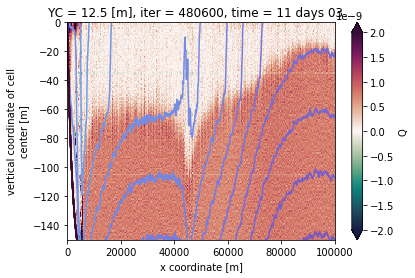

In [ ]:
clim = 2e-9
tdays = 14
ds['Q'].sel(time=np.timedelta64(tdays, 'D'), method='nearest').squeeze().plot(vmin=-clim, vmax=clim, cmap=cmo.curl)
ds['rho'].sel(time=np.timedelta64(tdays, 'D'), method='nearest').squeeze().plot.contour(vmin=1026.5, vmax=1027.5, levels=40, cmap=cmo.dense)
plt.ylim(-150, 0)
plt.xlim(0,100e3)
plt.show()

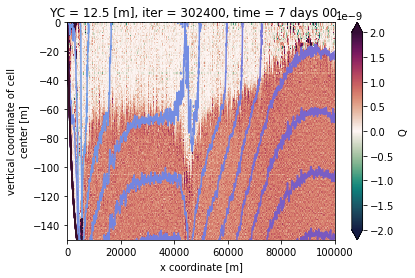

In [ ]:
clim = 2e-9
tdays = 7
ds['Q'].sel(time=np.timedelta64(tdays, 'D'), method='nearest').squeeze().plot(vmin=-clim, vmax=clim, cmap=cmo.curl)
ds['rho'].sel(time=np.timedelta64(tdays, 'D'), method='nearest').squeeze().plot.contour(vmin=1026.5, vmax=1027.5, levels=40, cmap=cmo.dense)
plt.ylim(-150, 0)
plt.xlim(0,100e3)
plt.show()

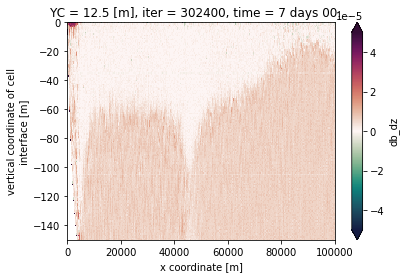

In [ ]:
tdays = 7
ds['db_dz'].sel(time=np.timedelta64(tdays, 'D'), method='nearest').squeeze().plot(vmin=-5e-5, vmax=5e-5, cmap=cmo.curl)
plt.ylim(-150, 0)
plt.xlim(0, 100e3)
plt.show()

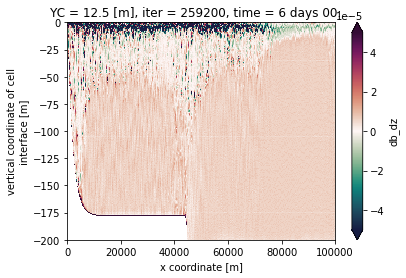

In [ ]:
tdays = 6
ds['db_dz'].sel(time=np.timedelta64(tdays, 'D'), method='nearest').squeeze().plot(vmin=-5e-5, vmax=5e-5, cmap=cmo.curl)
plt.ylim(-200, 0)
plt.xlim(0, 100e3)
plt.show()

In [ ]:
da_volume_transport = (ds['VVEL'] * ds['drF'] * ds['dxG']).sum(['XC', 'Z']).squeeze()

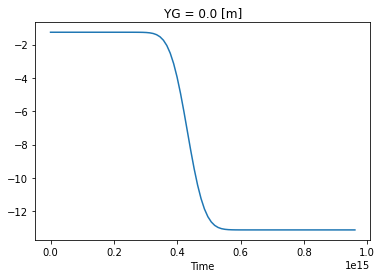

In [ ]:
(da_volume_transport * 1e-6).plot()

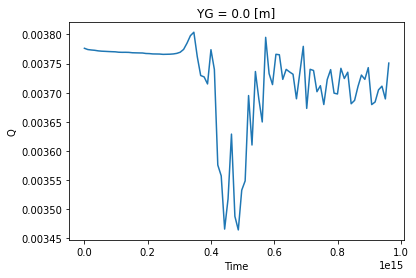

In [ ]:
ds['Q'].sum(['Zl', 'XG']).squeeze().plot()

In [ ]:
da_wprime = ds['WVEL'] - ds['WVEL'].mean('time')
da_bprime = grid.interp(ds['b'] - ds['b'].mean('time'), 'Z', boundary='extend', to='right')


In [ ]:
Kd = - (da_wprime * da_bprime).mean() / ds['db_dz']

/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


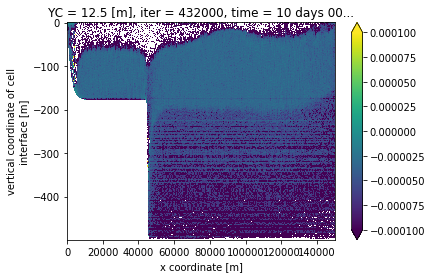

In [ ]:
Kd.isel(time=80).plot(vmin=-1e-4, vmax=1e-4)

In [16]:
Kd.min().values

/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


array(-0.00020407)

(array([4.9000e+01, 4.9000e+01, 3.5000e+01, 5.1000e+01, 5.0000e+01,
        5.2000e+01, 4.3000e+01, 3.0000e+01, 3.4000e+01, 2.6000e+01,
        4.0000e+01, 2.1000e+01, 1.3000e+01, 1.3000e+01, 8.0000e+00,
        5.0000e+00, 2.0000e+00, 5.0000e+00, 4.0000e+00, 1.0000e+00,
        1.5000e+01, 0.0000e+00, 1.0000e+00, 3.0000e+00, 1.3000e+01,
        2.3000e+01, 6.9000e+01, 1.2800e+02, 1.5500e+02, 2.1800e+02,
        2.5300e+02, 2.8400e+02, 2.8900e+02, 2.3400e+02, 2.6100e+02,
        3.9100e+02, 5.8000e+02, 7.5800e+02, 1.0690e+03, 1.5640e+03,
        2.3220e+03, 3.6610e+03, 5.8070e+03, 8.0460e+03, 1.0771e+04,
        1.0508e+04, 1.2093e+04, 1.5071e+04, 1.8027e+04, 1.8173e+04]),
 array([-300., -294., -288., -282., -276., -270., -264., -258., -252.,
        -246., -240., -234., -228., -222., -216., -210., -204., -198.,
        -192., -186., -180., -174., -168., -162., -156., -150., -144.,
        -138., -132., -126., -120., -114., -108., -102.,  -96.,  -90.,
         -84.,  -78.,  -72.,  -66.

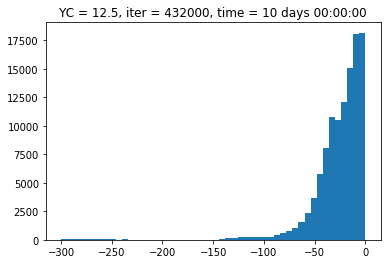

In [17]:
xr.where(ds['db_dz'].sel(Zl=slice(0, -300)) <= 0, ds['Zl'].sel(Zl=slice(0, -300)), np.NaN).isel(time=80).plot.hist(bins=50)

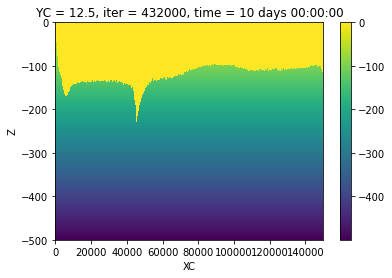

In [19]:
da_delta_rho_surf = ds['rho'] - ds['rho'].isel(Z=0)
xr.where(da_delta_rho_surf >= 0.05, ds['Z'], 0).isel(time=80).plot()

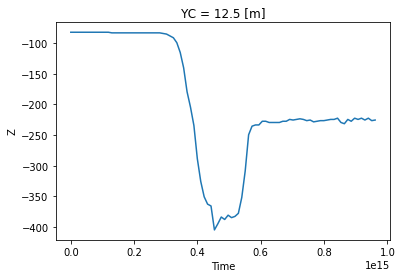

In [20]:
da_delta_rho_surf.where(lambda x: x<= 0.05).idxmax('Z').min('XC').plot()

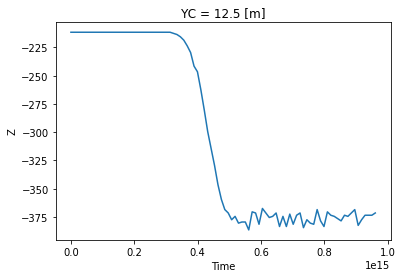

In [21]:
ds['rho'].where(lambda x: x <= 1027).idxmax('Z').min('XC').plot()

# Richardson numbers

In [22]:
dudz = grid.interp(grid.diff(ds['UVEL'], 'Z', to='right', boundary='extend'), 'X', boundary='fill')
dvdz = grid.interp(grid.diff(ds['VVEL'], 'Z', to='right', boundary='extend'), 'Y', boundary='fill')

Ri = ds['db_dz'] / (np.square(dudz) + np.square(dvdz))

/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


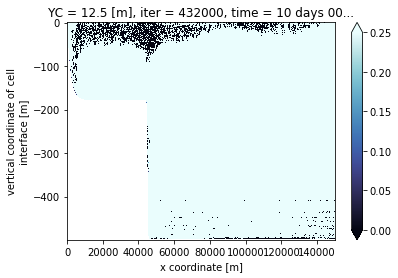

In [23]:
Ri.isel(time=80).plot(vmin=0, vmax=0.25, cmap=cmo.ice)

# Water mass transformation

In [24]:
ds['rhoTEND'] = - data_nml['parm01']['rhonil'] * data_nml['parm01']['talpha'] * ds['TOTTTEND']
ds['bTEND'] = pvcalc.calculate_buoyancy(ds['rhoTEND'])
ds['hTEND'] = ds['bTEND'] / grid.interp(ds['db_dz'], 'Z', boundary='fill')

/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


(0.0, 100000.0)

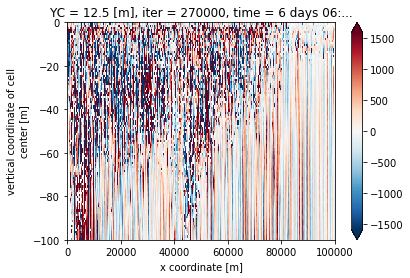

In [25]:
(ds['hTEND'] * ds['dxF'] * 100e3 / 1e6).isel(time=50).plot(robust=True)
plt.ylim(-100, 0)
plt.xlim(0, 100e3)

# Volumes between isopycnals

- First we need to choose some appropriate density classes
- Then we need to calculate the volumes in these over time and the rate of change of these volumes

array(1027.1211, dtype=float32)

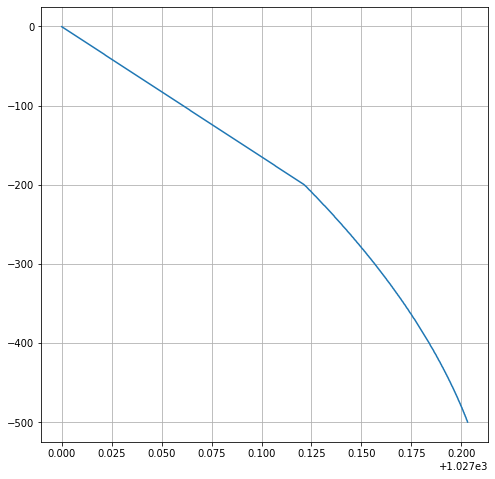

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.plot(ds['rhoRef'], ds['Z'])
ax.grid()

ds['rhoRef'].sel(Z=-200, method='nearest').values

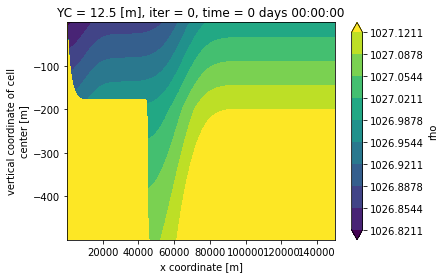

In [27]:
ds['rho'].isel(time=0).squeeze().plot.contourf(levels=10, vmin=1026.8211, vmax=1027.1211)

from the above I'm thinking let's choose density clasees of:
- $\rho \leq 1026.92$ (shelf waters)
- $1026.92 < \rho \leq 1026.98$ (current core)
- $1026.98 < \rho \leq 1027.05$ (surface waters)
- $1027.05 < \rho \leq \rho_{ref}(Z=-200 m) = 1027.1211$ (intermediate deep waters)
- $\rho > \rho_{ref}(Z=-200 m) = 1027.1211$ (deep waters)

And now we can calculate the volume within these classes

In [28]:
density_class_boundaries = np.array([1026.92, 1026.98, 1027.05, 1027.1211])
class_coords = {'classs': ('classs', range(0, len(density_class_boundaries) + 1)),
                'rho_upper': ('classs', np.insert(density_class_boundaries, 0, 0)),
                'rho_lower': ('classs', np.append(density_class_boundaries, np.inf)),
                'XC': ds['XC'],
                'XG': ds['XG'],
                'YC': ds['YC'],
                'YG': ds['YG'],
                'Z': ds['Z'],
                'Zl': ds['Zl'],
                'Zu': ds['Zu'],
                'Zp1': ds['Zp1'],}

ds_class = xr.Dataset(coords=class_coords)
ds_class['rho'] = ds['rho'] * ds['NaNmaskC'] * xr.ones_like(ds_class['classs'])
ds_class['mask'] = xr.where(ds_class['rho'] <= ds_class['rho_lower'], True, False) * xr.where(ds_class['rho'] > ds_class['rho_upper'], True, False)

def invert_bool_mask(da):
    return xr.where(da == True, False, True)

def dVol_dt(classMask, hTend):
    db_dz_mask = grid.interp(xr.where(ds['db_dz'] == 0, 0, ds['db_dz']), 'Z',boundary='extend')
    hTends = classMask * (invert_bool_mask(classMask.shift({'Z': 1})) + -1 * invert_bool_mask(classMask.shift({'Z': -1}))) * hTend * db_dz_mask
    VolTend = (hTends.sum('Z') * hTend['dxF']).sum('XC')
    return VolTend

ds_class['volTEND'] = dVol_dt(ds_class['mask'], ds['hTEND'])
ds_class['vol'] = (ds_class['mask'] * ds['drF']).sum(['Z', 'XC'])


In [40]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=2, processes=True,
                       threads_per_worker=4,)
client = Client(cluster)

client

/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43991 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43991/status,
Dashboard: http://127.0.0.1:43991/status,Workers: 2
Total threads: 8,Total memory: 503.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42417,Workers: 2
Dashboard: http://127.0.0.1:43991/status,Total threads: 8
Started: Just now,Total memory: 503.37 GiB
Comm: tcp://127.0.0.1:45143,Total threads: 4
Dashboard: http://127.0.0.1:34279/status,Memory: 251.68 GiB
Nanny: tcp://127.0.0.1:37911,


In [41]:
ds_class['volTEND'].squeeze().compute()

/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
2022-08-09 16:17:14,384 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:46453 -> tcp://127.0.0.1:45143
Traceback (most recent call last):
  File "/work/n01/n01/fwg/irm

KilledWorker: ("('xarray-iter-58af912a3022cf81064545b149d7b8b2', 0)", <WorkerState 'tcp://127.0.0.1:39261', name: 0, status: closed, memory: 0, processing: 135>)

In [33]:
ds_class['volTEND'] = ds_class['volTEND'].compute()

fig, ax = plt.subplots()
for classs in range(ds_class.dims['classs']):
    ax.plot(ds_class['time'], ds_class['volTEND'].isel(classs=classs), label=classs)

ax.legend()

/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
2022-08-09 16:13:16,955 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:32841 -> tcp://127.0.0.1:45249
Traceback (most recent call last):
  File "/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/tornado/iostream.py", line 867, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
  File "/work/n01/n01/fwg/irminger-proj/irminger-proj/lib/python3.8/site-packages/tornado/iostream.py", line 1140, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception w

KilledWorker: ("('broadcast_to-d4d7987535cb39b0b1c666c2d971ef60', 60, 0, 0, 0, 0)", <WorkerState 'tcp://127.0.0.1:38173', name: 1, status: closed, memory: 0, processing: 242>)

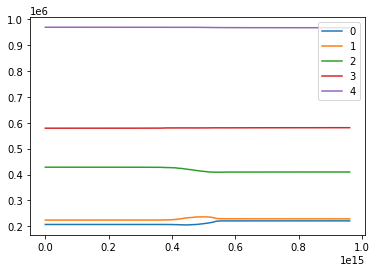

In [32]:
ds_class['vol'] = ds_class['vol'].compute()

fig, ax = plt.subplots()
for classs in range(ds_class.dims['classs']):
    ax.plot(ds_class['time'], ds_class['vol'].isel(classs=classs), label=classs)
    
ax.legend()